In [1]:
import sys
sys.path.append('../src/')

In [2]:
# TODO: Add code definitions here
import json
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
from learning import NetworkBGP
%matplotlib inline

## Opening Data

In [3]:
with open('../data/extracted_one_min_nov15.json') as f:
    full = json.load(f)
full[:3]

[{'time': 1542313320,
  'composite': {'prefix': '2620:0:2f0::', 'mask': 48, 'dest': 32629},
  'full_path': [63956, 4637, 174, 32629]},
 {'time': 1542313320,
  'composite': {'prefix': '2a0b:d080::', 'mask': 32, 'dest': 205747},
  'full_path': [63956, 13030, 60804, 174, 6830, 205747]},
 {'time': 1542313320,
  'composite': {'prefix': '94.185.102.0', 'mask': 24, 'dest': 198013},
  'full_path': [2914, 3356, 3549, 5392, 5392, 198013]}]

## Creating a Network

In [4]:
net_manager = NetworkBGP(full, 100, lr=0.01, cw=[0.05, 1])

There are 8768 messages to be labeled
There are 2191 messages to be labeled


In [5]:
net_manager.Xtrain[:3]

tensor([[-1.6660,  2.6084,  1.3810, -0.4342],
        [-1.6660,  2.6128,  0.3198,  1.4531],
        [-1.6660, -0.3919, -0.2108,  1.3687]], dtype=torch.float64)

In [6]:
net_manager.net

DistinctNN(
  (h1): Linear(in_features=4, out_features=100, bias=True)
  (a1): ReLU()
  (h2): Linear(in_features=100, out_features=100, bias=True)
  (a2): ReLU()
  (h3): Linear(in_features=100, out_features=100, bias=True)
  (a3): ReLU()
  (raw_out): Linear(in_features=100, out_features=2, bias=True)
  (out_act): LogSoftmax()
)

## Training the Network

In [7]:
start = time.time()
losses = net_manager.train_network(num_iterations=800)
print('Training took {}'.format(time.time() - start))

Training took 35.8525288105011


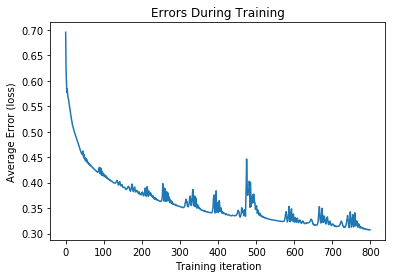

In [8]:
plt.plot(losses)
plt.ylabel('Average Error (loss)')
plt.xlabel('Training iteration')
plt.title('Errors During Training')
plt.show()

In [9]:
losses[-1]

[array(0.30724252)]

## Testing the Network
### Data used for Training

In [32]:
alpha=0.1

In [33]:
predicted = torch.max(net_manager.net(net_manager.Xtrain), 1)[1].numpy()
actual = net_manager.Ttrain.numpy()

In [34]:
predicted

array([1, 1, 1, ..., 0, 1, 1])

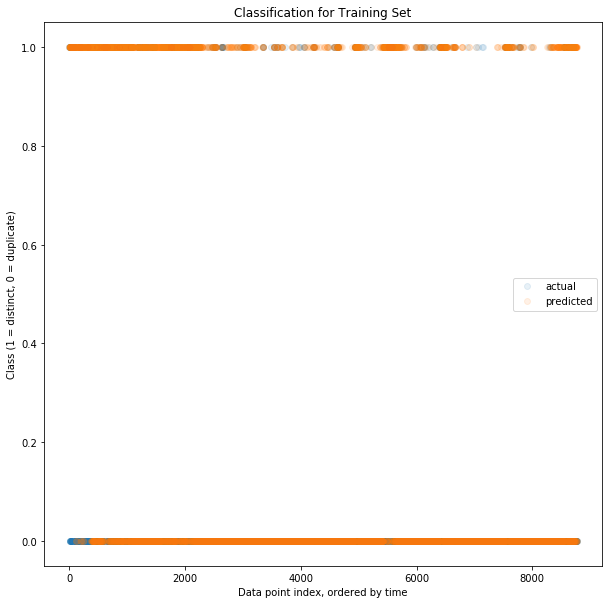

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.plot(actual, 'o', alpha=alpha, label='actual')
ax.plot(predicted, 'o', alpha=alpha, label='predicted')
plt.legend()
plt.ylabel('Class (1 = distinct, 0 = duplicate)')
plt.xlabel('Data point index, ordered by time')
plt.title('Classification for Training Set')
plt.show()

In [37]:
net_manager.get_correct(predicted, actual)

(0.8110173357664233, 0.8021390374331551, 0.9092159559834938)

In [38]:
total_correct, duplicate_correct, distinct_correct = net_manager.get_correct(predicted, actual)
print('% of total correctly classified: {:.2%}'.format(total_correct))
print('% of duplicate messages correctly classified: {:.2%}'.format(duplicate_correct))
print('% of distinct messages correctly classified distinct: {:.2%}'.format(distinct_correct))

% of total correctly classified: 81.10%
% of duplicate messages correctly classified: 80.21%
% of distinct messages correctly classified distinct: 90.92%


### On New Data

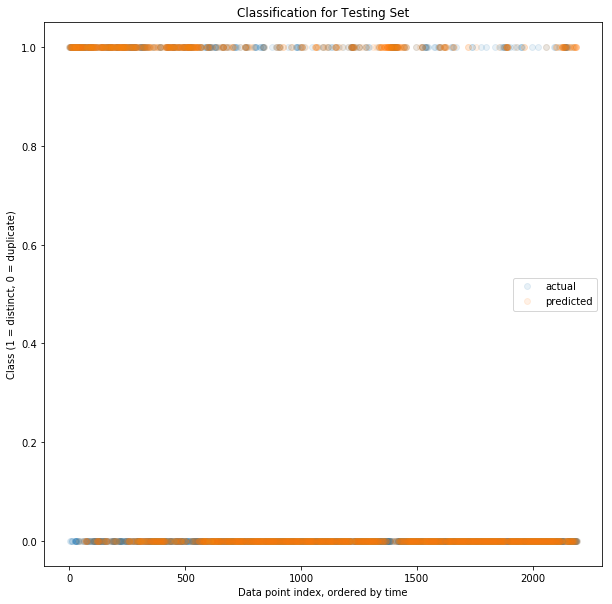

In [39]:
predicted = net_manager.get_predicted_classes(net_manager.net(net_manager.Xtest))
actual = net_manager.Ttest.numpy()
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.plot(actual, 'o', alpha=alpha, label='actual')
ax.plot(predicted, 'o', alpha=alpha, label='predicted')
plt.legend()
plt.ylabel('Class (1 = distinct, 0 = duplicate)')
plt.xlabel('Data point index, ordered by time')
plt.title('Classification for Testing Set')
plt.show()

In [40]:
total_correct, duplicate_correct, distinct_correct = net_manager.get_correct(predicted, actual)
print('% of total correctly classified: {:.2%}'.format(total_correct))
print('% of duplicate messages correctly classified: {:.2%}'.format(duplicate_correct))
print('% of distinct messages correctly classified distinct: {:.2%}'.format(distinct_correct))

% of total correctly classified: 77.86%
% of duplicate messages correctly classified: 80.94%
% of distinct messages correctly classified distinct: 65.01%
